# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from sklearn.model_selection import train_test_split

from lightning import Trainer

from src.util.torch_device import resolve_torch_device
from src.util.patches import extract_patches, scale_patched
from src.data.indian_pines import load_indian_pines
from src.model.hsic import HyperSpectralImageClassifier
from src.model.fully_convolutional_lenet import FullyConvolutionalLeNet
from src.visualization.plot import plot_segmentation_comparison
from src.model.hsi_vit import HsiVisionTransformer, Conv3DStem
from src.data.dataset_decorator import UnlabeledDatasetDecorator

2. Prepare env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

batch_size = 32
patch_size = 9
num_epochs = 12
learning_rate = 1e-3

device = resolve_torch_device()

In [3]:
torch.set_float32_matmul_precision("medium")

In [4]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [5]:
from src.data.indian_pines import load_indian_pines_v2
from src.util.image import scale_image


image, tr, te, labels = load_indian_pines_v2()
_, image = scale_image(image)

image_h, image_w, image_c = image.shape

In [6]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

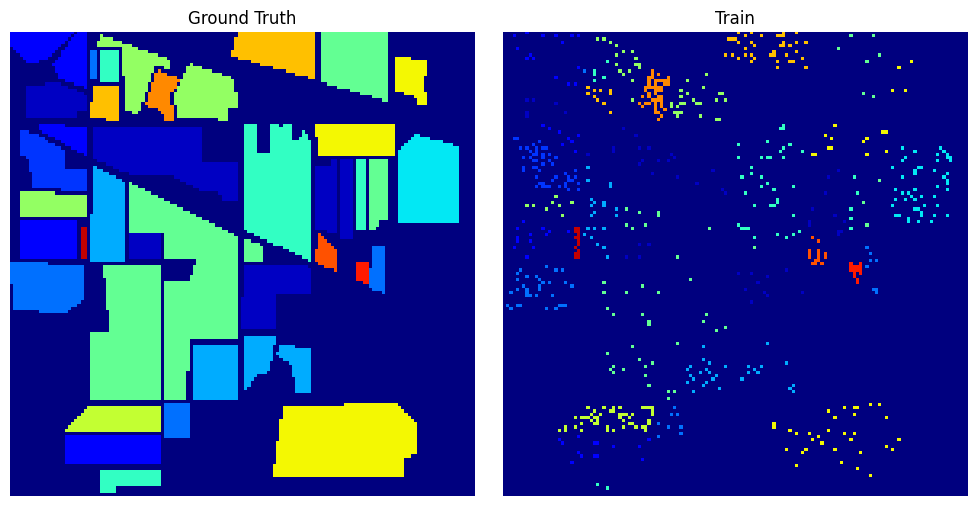

In [7]:
plot_segmentation_comparison(labels, tr, title2="Train")

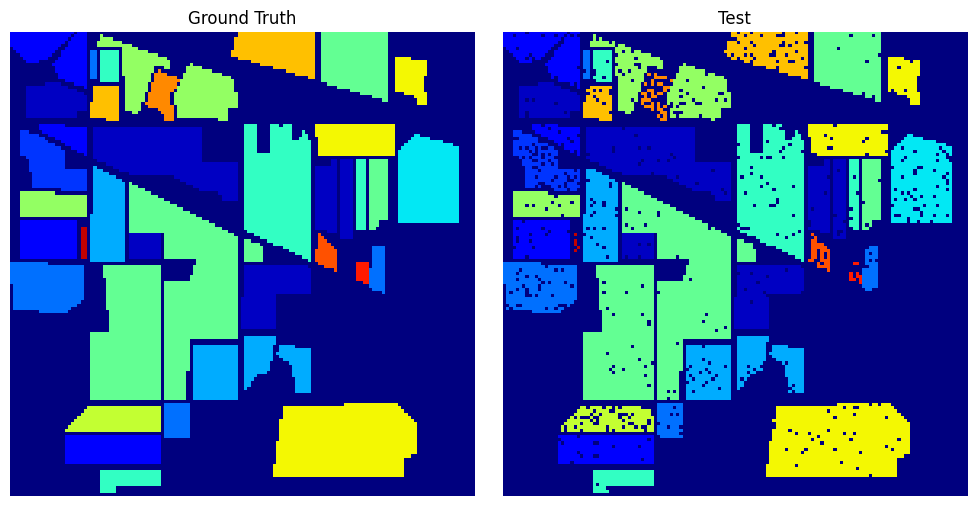

In [8]:
plot_segmentation_comparison(labels, te, title2="Test")

In [9]:
from src.data.hsi import (
    chooose_train_and_test_point,
    mirror_hsi,
    train_and_test_data,
    train_and_test_label,
)


(
    total_pos_train,
    total_pos_test,
    total_pos_true,
    number_train,
    number_test,
    number_true,
) = chooose_train_and_test_point(tr, te, labels, num_classes - 1)
mirror_image = mirror_hsi(image_h, image_w, image_c, image, patch=patch_size)
x_train, x_test, x_true = train_and_test_data(
    mirror_image,
    image_c,
    total_pos_train,
    total_pos_test,
    total_pos_true,
    patch=patch_size,
)
y_train, y_test, y_true = train_and_test_label(
    number_train, number_test, number_true, num_classes - 1
)

# x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(
#     torch.FloatTensor
# )  # [695, 200, 7, 7]
# y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # [695]

# x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(
#     torch.FloatTensor
# )  # [9671, 200, 7, 7]
# y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # [9671]

Train data shape = (695, 9, 9, 200), type = float64
Test data shape = (9671, 9, 9, 200), type = float64


In [10]:
def gain_neighborhood_band(x_train, band, band_patch, patch=5):
    nn = band_patch // 2
    pp = (patch * patch) // 2
    x_train_reshape = x_train.reshape(x_train.shape[0], patch * patch, band)
    x_train_band = np.zeros(
        (x_train.shape[0], patch * patch * band_patch, band), dtype=float
    )
    # 中心区域
    x_train_band[:, nn * patch * patch : (nn + 1) * patch * patch, :] = x_train_reshape
    # 左边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[:, i * patch * patch : (i + 1) * patch * patch, : i + 1] = (
                x_train_reshape[:, :, band - i - 1 :]
            )
            x_train_band[:, i * patch * patch : (i + 1) * patch * patch, i + 1 :] = (
                x_train_reshape[:, :, : band - i - 1]
            )
        else:
            x_train_band[:, i : (i + 1), : (nn - i)] = x_train_reshape[
                :, 0:1, (band - nn + i) :
            ]
            x_train_band[:, i : (i + 1), (nn - i) :] = x_train_reshape[
                :, 0:1, : (band - nn + i)
            ]
    # 右边镜像
    for i in range(nn):
        if pp > 0:
            x_train_band[
                :,
                (nn + i + 1) * patch * patch : (nn + i + 2) * patch * patch,
                : band - i - 1,
            ] = x_train_reshape[:, :, i + 1 :]
            x_train_band[
                :,
                (nn + i + 1) * patch * patch : (nn + i + 2) * patch * patch,
                band - i - 1 :,
            ] = x_train_reshape[:, :, : i + 1]
        else:
            x_train_band[:, (nn + 1 + i) : (nn + 2 + i), (band - i - 1) :] = (
                x_train_reshape[:, 0:1, : (i + 1)]
            )
            x_train_band[:, (nn + 1 + i) : (nn + 2 + i), : (band - i - 1)] = (
                x_train_reshape[:, 0:1, (i + 1) :]
            )
    return x_train_band

In [11]:
gain_neighborhood_band(x_train, image_c, 5, patch_size).shape

(695, 405, 200)

In [12]:
x_train.shape

(695, 9, 9, 200)

In [ ]:
y_train.shape

In [ ]:
x_test.shape

In [ ]:
y_test.shape

In [ ]:
from src.visualization.plot import plot_numbers_distribution


plot_numbers_distribution(y_true)

In [ ]:
Label_train = data.TensorDataset(x_train, y_train)
Label_test = data.TensorDataset(x_test, y_test)

In [ ]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [ ]:
scale, x = scale_patched(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=random_seed, stratify=y
)

In [ ]:
x_tensor = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2) 
y_tensor = torch.tensor(x, dtype=torch.long)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

In [ ]:
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)
full_dataset = data.TensorDataset(x_tensor, y_tensor)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=cpu_count,
    persistent_workers=True,
)

In [ ]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

# CNN

1. Train model

In [ ]:
model = HyperSpectralImageClassifier(
    FullyConvolutionalLeNet(image_c, num_classes), num_classes, lr=learning_rate
)

trainer = Trainer(accelerator="auto", devices=1, max_epochs=num_epochs)

In [ ]:
trainer.fit(model, train_loader, test_loader)

2. Display prediction

In [ ]:
y_pred = model(x_tensor)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)

# ViT

In [ ]:
from torch import nn, optim

from src.model.autoencoder import AutoEncoder
from src.model.hsi_vit import UnConv3DStem
from src.trainer.autoencoder_trainer import AutoEncoderTrainer

epochs=3

autoencoder = AutoEncoder(Conv3DStem(), UnConv3DStem())

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
autoencoder_trainer = AutoEncoderTrainer(
    criterion,
    epochs,
    optimizer,
)

In [ ]:
autoencoder_trainer.fit(autoencoder, train_loader)

1. Train model

In [ ]:
patch_size=16
num_layers=5
num_heads=4
hidden_dim=64
mlp_dim=8
learning_rate=1e-3
num_epochs=12

In [ ]:
model = HyperSpectralImageClassifier(
    HsiVisionTransformer(
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
    ),
    num_classes,
    lr=learning_rate,
)

trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

In [ ]:
trainer.fit(model, train_loader, test_loader)

2. Display prediction

In [ ]:
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=True,
    num_workers=cpu_count,
    persistent_workers=True,
)

y_pred = trainer.predict(model, predict_loader)

In [ ]:
y_pred = torch.cat(y_pred, dim=0)

In [ ]:
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

In [ ]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy(), num_classes)